#### Tasks
1. Create the most accurate classifier (evaluation metric: accuracy rate) for the data, as measured by the
test data.
2. Write a 8-12 page slides summarizing your approach to:  
    (a) cleaning and preparing the data for modeling - Assumption: Missing dates implying no delivery  
    (b) formulating the model design matrix - Definition of features  
    (c) building the model and tuning parameters - Different models tested and describe the tuning process  
    (d) validating the model by training & validation sets, or other approaches - 5-fold Cross-Validation   
    (e) comparing results from all attempts  
    (f) findings from the data and challenges from this contest.  

### **Imports**
---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import OrdinalEncoder, Normalizer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV

from datasets import get_training
from prep import DataPrep
from model_testing import make_predictions, evaluate_confusion_matrix

### **Get and Prepare Training Data**
---

*Read training X and y frames*

In [3]:
X, y = get_training()
df = X.join(y)
df = df[df['price'] <= 600]

*Create training and validation splits*
- *Training (Sept. 1st, 2021 - Jan. 31st, 2022)*
- *Validation (Feb. 1st, 2022 - Feb. 28th, 2022)*

In [4]:
# Create Training Split (first four and a half months)
train_set = df[pd.to_datetime(df['orderDate']) < pd.to_datetime('2022-02-01')].reset_index(drop=True)
X_train = train_set.drop(columns='return')
y_train = train_set['return']

# Create Validation Split (last month and a half)
validation_set = df[pd.to_datetime(df['orderDate']) >= pd.to_datetime('2022-02-01')].reset_index(drop=True)
X_validation = validation_set.drop(columns='return')
y_validation = validation_set['return']

*Clean and Prepare Training and Validation Data*

In [5]:
X_train_prepped = DataPrep().run(X_train)
X_validation_prepped = DataPrep().run(X_validation)

### **Preprocessing**
---

*Preprocessing Steps*
1. Encode the categorical variables
    - OneHotEncoder for non-tree models
    - OrdinalEncoder for tree-based models
2. Impute missing values on numeric fields
    - SimpleImputer [mean, median, most_frequent]
3. Scale numerical values
4. [optional] normalize features

*Preprocessing Notes*
- For tree-based models, do not one-hot encode, instead use ordinal encoding. Tree-based models can basically learn the same information from an ordinal encoded feature as from a one-hot encoded feature, even if the features themselves are unordered.
- Cross-Validation on the entire pipeline
    - Data is split and then applies the pipeline steps (good) instead of preprocessing the data and then do cross-validation on just the model (bad - Data Leakage)
    - Preprocessing before splitting the data does not properly simulate reality
    - Splitting and then preprocessing does simulate reality, which is the entire purpose of cross-validation
    

*Create Preprocessors*

In [6]:
# Create lists of numerical and categorical columns in X data
numeric_cols = X_train_prepped.select_dtypes(include=np.number).columns
categorical_cols = X_train_prepped.select_dtypes(exclude=np.number).columns

# Create a preprocessor for tree-based models
treebased_preprocessor = ColumnTransformer([
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ]), categorical_cols),
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('normalize', Normalizer(norm='max'))
        ]), numeric_cols)
    ])

# Create a generic preprocessor
generic_preprocessor = ColumnTransformer([
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]),categorical_cols),
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('normalize', Normalizer(norm='max'))
        ]), numeric_cols)
    ])

### **Model Development and Testing**
---

#### **Model 1: Decision Tree Classifier**

Training Accuracy: 0.7868
Test Accuracy: 0.7727
Precision: 0.7417
Recall: 0.8532
F1 Score: 0.7936

---CONFUSION MATRIX---
True Positives: 16857
True Negatives: 12958
False Positives: 5870
False Negatives: 2901


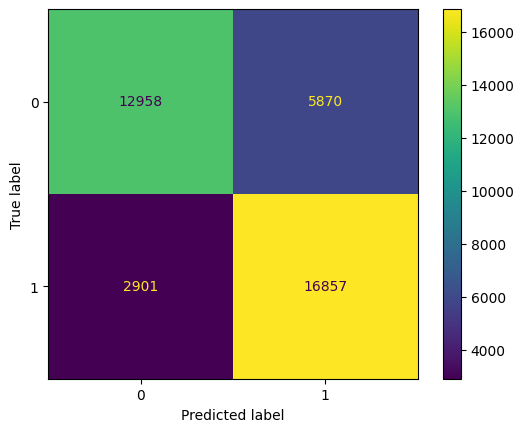

In [7]:
from sklearn.tree import DecisionTreeClassifier

# Initilize Classifier with the best parameters
clf = DecisionTreeClassifier(
    min_samples_split=4,
    max_depth=11,
    splitter='best',
    criterion='gini'
)

# Create a ML Pipeline Instance with the Tuned Classifier
pipeline = Pipeline([
    ('preprocessor', treebased_preprocessor),
    ('model', clf)])

evaluate_confusion_matrix(pipeline, X_train_prepped, X_validation_prepped, y_train, y_validation)

#### **Model 2: XGBoost**

In [ ]:
from xgboost import XGBClassifier

In [96]:
clf = XGBClassifier()

# Create Pipeline
pipeline = Pipeline([
    ('preprocessor', generic_preprocessor),
    ('model', clf)])

# Create parameter grid for pipline
pipeline_param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'preprocessor__num__normalizer__norm': ['l1', 'l2', 'max'],
    'model__n_estimators': [100, 200, 300, 400, 500],
    'model__learning_rate': [0.01, 0.5, 0.1, 1],
    'model__min_child_weight': [0, 2, 5, 7, 10]
}

# Perform search
search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=pipeline_param_grid,
    n_iter=2,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

search.fit(X_train_prepped, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               Index(['color', 'salutation', 'state'], dtype='object')),
                                                                              ('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('normalizer',
                                                                                                Norma...
                                                            predictor=None,
                                                            random_state=None, ...))]),
                   n_iter=2, n_jobs=-1,
                   param_distributions={'model__learning_rate': [0.01, 0.5, 0.1,
                                                                 1],
                                        'model__min_child_weight': [0, 2, 5, 7,
                                                                    10],
                                        'model__n_estimators': [100, 200, 300,
                                                                400, 500],
                                        'preprocessor__num__imputer__strategy': ['mean',
                                                                                 'median',
                                                                                 'most_frequent'],
                                        'preprocessor__num__normalizer__norm': ['l1',
                                                                                'l2',
                                                                                'max']},
                   scoring='accuracy')

Training Accuracy: 0.7876
Test Accuracy: 0.7843
Precision: 0.7579
Recall: 0.8504
F1 Score: 0.8015

---CONFUSION MATRIX---
True Positives: 16802
True Negatives: 13462
False Positives: 5366
False Negatives: 2956


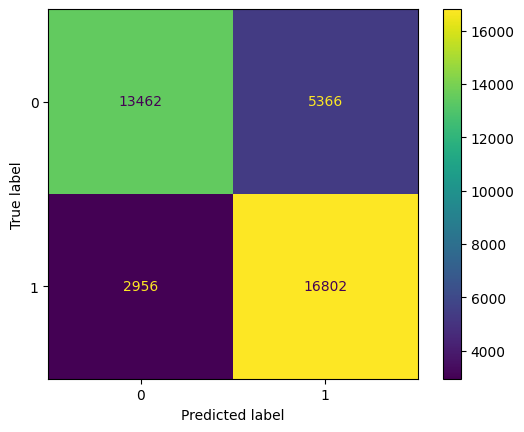

In [10]:
clf = XGBClassifier(
    n_estimators=300,
    objective='binary:logistic',
    tree_method='hist',
    learning_rate=0.1,
    max_depth=4,
    booster='gbtree',
    min_child_weight=5,
    gamma=0,
    subsample=1,
    scale_pos_weight=1,
    eval_metric='error'
)

pipeline = Pipeline([
    ('preprocessor', generic_preprocessor),
    ('model', clf)])

evaluate_confusion_matrix(pipeline, X_train_prepped, X_validation_prepped, y_train, y_validation)

#### **Model 3: Gradient Boosting**

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

Training Accuracy: 0.7874
Test Accuracy: 0.7793
Precision: 0.746
Recall: 0.8627
F1 Score: 0.8001

---CONFUSION MATRIX---
True Positives: 17046
True Negatives: 13024
False Positives: 5804
False Negatives: 2712


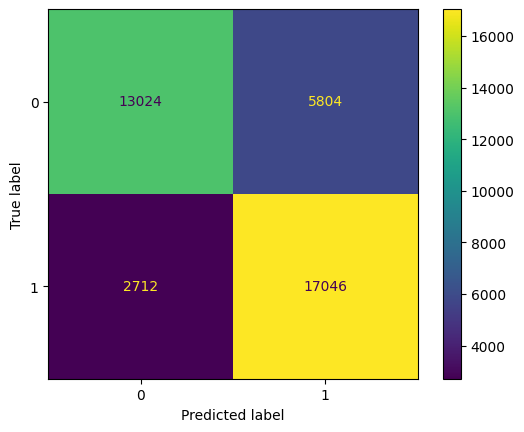

In [13]:
# Initialize Base Classifier
clf = GradientBoostingClassifier(
    min_samples_split=10,
    max_depth=8,
    n_estimators=25,
    max_features=9
)

# Initialize ML Pipeline
pipeline = Pipeline([
    ('preprocessor', treebased_preprocessor),
    ('model', clf)])

evaluate_confusion_matrix(pipeline, X_train_prepped, X_validation_prepped, y_train, y_validation)

#### **Model 4: SGDClassifier**

In [15]:
from sklearn.linear_model import SGDClassifier

Training Accuracy: 0.7385
Test Accuracy: 0.7453
Precision: 0.7508
Recall: 0.7524
F1 Score: 0.7516

---CONFUSION MATRIX---
True Positives: 14865
True Negatives: 13894
False Positives: 4934
False Negatives: 4893


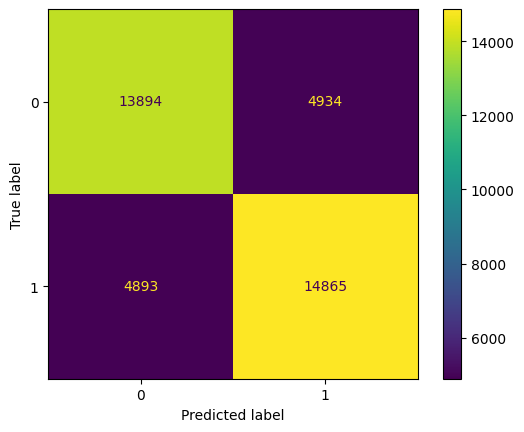

In [20]:
# Initialize Tuned Classifier
clf = SGDClassifier(
    penalty='l1',
    max_iter=1000,
    loss='modified_huber',
    alpha=0.0001
)

# Initialize ML Pipeline with Tuned Classifier
pipeline = Pipeline([
    ('preprocessor', generic_preprocessor),
    ('model', clf)])

evaluate_confusion_matrix(pipeline, X_train_prepped, X_validation_prepped, y_train, y_validation)

#### **Model 5: Multi-Layer Perceptron Classifier**

In [78]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier()

pipeline = Pipeline([
    ('preprocessor', generic_preprocessor),
    ('model', clf)])

evaluate_confusion_matrix(pipeline, X_train_prepped, X_validation_prepped, y_train, y_validation)

c:\Users\Josh Ellis\Anaconda3\envs\uno-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Josh Ellis\Anaconda3\envs\uno-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training Score: 0.7881386345346586
Validation Score: 0.7710568600010367


#### **Model 6: Random Forest Classifier**

In [79]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    bootstrap=True,
    max_depth=10,
    max_features='log2',
    min_samples_leaf=2,
    min_samples_split=12,
    n_estimators=500
)

pipeline = Pipeline([
    ('preprocessor', treebased_preprocessor),
    ('model', clf)])

evaluate_confusion_matrix(pipeline, X_train_prepped, X_validation_prepped, y_train, y_validation)

Training Score: 0.781581007895252
Validation Score: 0.7723267506349453


## Fit Model and Predict Test Set        

---

### Fit model and make predictions

In [98]:
from xgboost import XGBClassifier

# Get X and y data
X, y = get_training()

# Remove price outliers
training_data = X.join(y)
training_data = df[df['price'] <= 600].reset_index(drop=True)
X = training_data.drop(columns='return')
y = training_data['return']

# Prepare and clean X Training data
X_prepped = DataPrep().run(X)

# Create lists of numerical and categorical columns in X data
numeric_cols = X_prepped.select_dtypes(include=np.number).columns
categorical_cols = X_prepped.select_dtypes(exclude=np.number).columns

# Initialize the preprocessor
preprocessor = ColumnTransformer([
    ('categorical_features', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]),categorical_cols),
    ('numeric_features', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('normalize', Normalizer(norm='max'))
        ]), numeric_cols)
    ])

# Tuned Classifier
clf = XGBClassifier(
    n_estimators=300,
    objective='binary:logistic',
    tree_method='hist',
    learning_rate=0.1,
    max_depth=4,
    booster='gbtree',
    min_child_weight=5,
    gamma=0,
    subsample=1,
    scale_pos_weight=1,
    eval_metric='error'
)

# ML Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', clf)])

# Fit base pipeline to training data
pipeline.fit(X_prepped, y)

make_predictions(pipeline, 'submission10_xgboost.csv')

In [90]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical_feature',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['color', 'salutation', 'state'], dtype='object')),
                                                 ('numeric_features',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('normalize',
                                                                   Normalizer(...
                               feature_types=None, gamma=0, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None, min_child_weight=5,
                               missing=nan, monotone_constraints=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])